In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pickle
import os
import sys
from ephys import core, events, rasters
from neuraltda import topology
import glob
import string
from scipy.io import wavfile
import scipy.signal as signal
from scipy.interpolate import interp1d
import seaborn as sns
import scipy.stats as st
sns.set_context('poster')
sns.set_style('white')

%pylab inline
reload(topology)

Populating the interactive namespace from numpy and matplotlib


<module 'neuraltda.topology' from '/home/brad/code/NeuralTDA/neuraltda/topology.pyc'>

In [42]:
maxt = 100
prefix = 'B999'
def plotBarcodeRecursive(resDict):
    
    if 'barcodes' in resDict.keys():
        barcodeDat = resDict['barcodes']
        bettis = barcodeDat.keys()
        for betti in bettis:
            bettiBarcode = barcodeDat[betti]
            nlines = len(bettiBarcode)
            ycoords = [[s,s] for s in range(nlines)]
            xcoords = [[s[0], s[1]+maxt*(s[1] < 0)] for s in bettiBarcode]
            fig = plt.figure()
            plt.plot(np.transpose(xcoords), np.transpose(ycoords))
            plt.title('Hstr: %s  Betti: %s' % (resDict['hstr'], betti))
            plt.show()
    else:
        for ind, k in enumerate(resDict.keys()):
            plotBarcodeRecursive(resDict[k])
            
def plotPersistenceDiagramRecursive(resDict):
    
    if 'barcodes' in resDict.keys():
        barcodeDat = resDict['barcodes']
        bettis = barcodeDat.keys()
        for betti in bettis:
            bettiBarcode = barcodeDat[betti]
            nlines = len(bettiBarcode)
            ycoords = [s[1]+max(max(bettiBarcode))*(s[1] < 0) for s in bettiBarcode]
            xcoords = [s[0] for s in bettiBarcode]
            fig = plt.figure()
            plt.plot(np.transpose(xcoords), np.transpose(ycoords), '.')
            plt.plot(np.linspace(0, maxt, 10), np.linspace(0, maxt, 10), 'k')
            plt.title('Hstr: %s  Betti: %s' % (resDict['hstr'], betti))
            plt.xlim([-2, maxt])
            plt.ylim([-2, maxt])
            plt.show()
    else:
        for ind, k in enumerate(resDict.keys()):
            plotPersistenceDiagramRecursive(resDict[k])


def plotBettiCurveRecursive(resDict):
    
    if 'bettis' in resDict.keys():
        bettiDat = resDict['bettis']
        bettis = len(bettiDat[0][1])
        for betti in range(bettis):
            ycoords = [s[1][betti] for s in bettiDat]
            xcoords = [s[0] for s in bettiDat]
            fig = plt.figure()
            plt.plot(np.transpose(xcoords), np.transpose(ycoords))
            plt.title('Hstr: %s  Betti: %s' % (resDict['hstr'], betti))
            plt.show()
    else:
        for ind, k in enumerate(resDict.keys()):
            plotBettiCurveRecursive(resDict[k])
            
def avgBettiRecursive(bettiDict, bettinum, runningSum, N, maxT, windt, dtOver=0.0):
    if 'bettis' in bettiDict.keys():
        bettiT = np.array([s[0] for s in bettiDict['bettis']])*((windt-dtOver)/1000.)
        maxT = max(bettiT)
        try:
            bettiB = np.array([s[1][bettinum] for s in bettiDict['bettis']])
        except:
            
            bettiB = np.zeros(len(bettiT))
        bfunc = interp1d(bettiT, bettiB, kind='zero', bounds_error=False, fill_value=(bettiB[0], bettiB[-1]))
        t = np.linspace(0, maxT, 1000)
        bvals = bfunc(t)
        return (runningSum + bvals, N+1, maxT)
    else:
        for k in bettiDict.keys():
            runningSum, N, maxT = avgBettiRecursive(bettiDict[k], bettinum, runningSum, N, maxT, windt, dtOver)
        return (runningSum, N, maxT)
    
def avgstdBettiRecursive(bettiDict, bettinum, bettiSave, N, maxT, windt, dtOver=0.0 ):
    if 'bettis' in bettiDict.keys():
        bettiT = np.array([s[0] for s in bettiDict['bettis']])*((windt-dtOver)/1000.)
        maxT = max(bettiT)
        try:
            bettiB = np.array([s[1][bettinum] for s in bettiDict['bettis']])
        except:
            
            bettiB = np.zeros(len(bettiT))
        bfunc = interp1d(bettiT, bettiB, kind='zero', bounds_error=False, fill_value=(bettiB[0], bettiB[-1]))
        t = np.linspace(0, maxT, 1000)
        bvals = np.array(bfunc(t))
        bettiSave = np.vstack((bettiSave, bvals))
        return (bettiSave, N+1, maxT)
    else:
        for k in bettiDict.keys():
            bettiSave, N, maxT = avgstdBettiRecursive(bettiDict[k], bettinum, bettiSave, N, maxT, windt, dtOver=dtOver)
        return (bettiSave, N, maxT) 
    
def computeAvgStdBettiCurve(resDict, stim, betti, windt):
    
    stimdata = resDict[stim]
    bettiSave = np.zeros(1000)
    bettiSave, N, maxT = avgstdBettiRecursive(stimdata, betti, bettiSave, 0, 0, windt)
    avgBetti = np.mean(bettiSave, axis=0)
    stdBetti = np.std(bettiSave, axis=0)
    semBetti = stdBetti / np.sqrt(N)
    ci95Betti = semBetti*st.t.interval(0.95, N-1)[1]
    t = np.linspace(0, maxT, len(avgBetti))
    
    return (avgBetti, stdBetti, ci95Betti, t, maxT)
    
def computeAvgBettiCurve(resDict, stim, betti, windt, dtOver=0.0):
    
    stimdata = resDict[stim]
    
    runningSum, N, maxT = avgBettiRecursive(stimdata, betti, np.zeros(1000), 0, 0, windt, dtOver=dtOver)
    avgBetti = runningSum / float(N)
    t = np.linspace(0, maxT, len(avgBetti))
    
    return (avgBetti, t, maxT)

def computeAvgBettiCurveSingleTrial(resDict, stim, trial, betti, windt, dtOver=0.0):
    stimdata = resDict[stim]
    trials = stimdata.keys()
    trialdata = stimdata[trial]
    runningSum, N, maxT = avgBettiRecursive(trialdata, betti, np.zeros(1000), 0, 0, windt, dtOver=dtOver)
    avgBetti = runningSum / float(N)
    t = np.linspace(0, maxT, len(avgBetti))
    
    return (avgBetti, t, maxT)

def plotAvgBettiCurves(avgBetti, t, betti, stim): 
    
    plt.figure()
    plt.plot(t, avgBetti)
    plt.title('Stim: %s Betti: %d' %(stim, betti))
    plt.ylim([0, max(avgBetti)+2])
    plt.xlim([0, max(t)])
    plt.show()
def plotStimAvgMinusTotalAvg(resDict, stim, betti):
    stimdata = resDict[stim]
    t = np.linspace(0, 2, 1000)
    runningSum, N = avgBettiRecursive(stimdata, betti, np.zeros(len(t)), 0, t)
    avgBetti = runningSum / float(N)
    
    totAvg, N = avgBettiRecursive(resDict, betti, np.zeros(len(t)), 0, t)
    totAvg = totAvg/float(N)
    
    
    plt.figure(figsize=(11, 8))
    plt.plot(t, avgBetti-totAvg)
    sns.despine()
    plt.title('Stim: %s Betti: %d' %(stim, betti))
    plt.ylim([-5, 5])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Difference')
    plt.savefig('{}-Stim_{}-Betti_{}.png'.format(prefix, stim, betti))
    plt.show()
    

In [32]:
resFname = '/Volumes/gentner/btheilma/experiments/B1075/phy041216/Pen01_Lft_AP300_ML700__Site03_Z2700__B1075_cat_P01_S03_1/20170220T170821Z-10.0-5.0-4.0-masterResults.pkl'
resFname = '/mnt/cube/btheilma/emily/B604/klusta/phy103116/Pen01_Lft_AP2300_ML1250__Site15_Z2780__B604_cat_P01_S15_1/Good_MUA_AllTrials_MasterResults/20170323T165656Z-25.0-12.5-13.0-masterResults.pkl'
with open(resFname, 'r') as f:
    mrDict = pickle.load(f)
    
print(mrDict.keys())
computationClass = 'permuted'
results = mrDict[computationClass]
resultsSh = mrDict['shuffledpermuted']
stims = results.keys()



['permuted', 'shuffledpermuted']


In [33]:
print(stims)

[u'T40S40D3', u'T3S8D40', u'T3S3D-1', u'T-1S-1D3', u'T3S3D40', u'T-1S-1D40', u'T40S70D3', u'T3S8D-1', u'T40S40D-1', u'T40S70D-1']


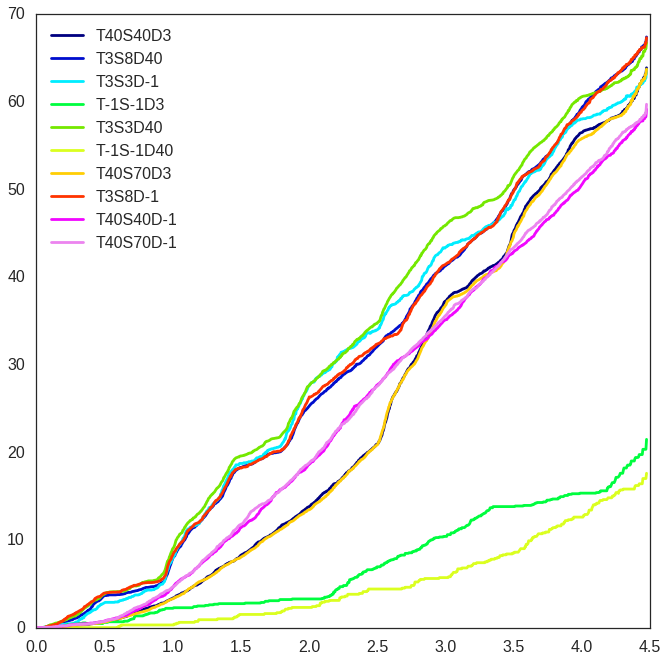

In [34]:
bettisave = np.zeros((1000, len(stims)))
betti = 1
windt = 25.0
for ind, stim in enumerate(stims):
    (avgBetti, t, maxT) = computeAvgBettiCurve(results, stim, betti, windt, dtOver=12.5)
    bettisave[:, ind] = avgBetti
plt.figure(figsize=(11,11))  
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(stims))])

plt.plot(t, bettisave)
plt.legend(stims, loc='left')
plt.savefig('/home/brad/B604_P01S15_Betti{}_dt{}-AllTrial_AllStims_GoodMUA_original.png'.format(betti, windt), format='png')

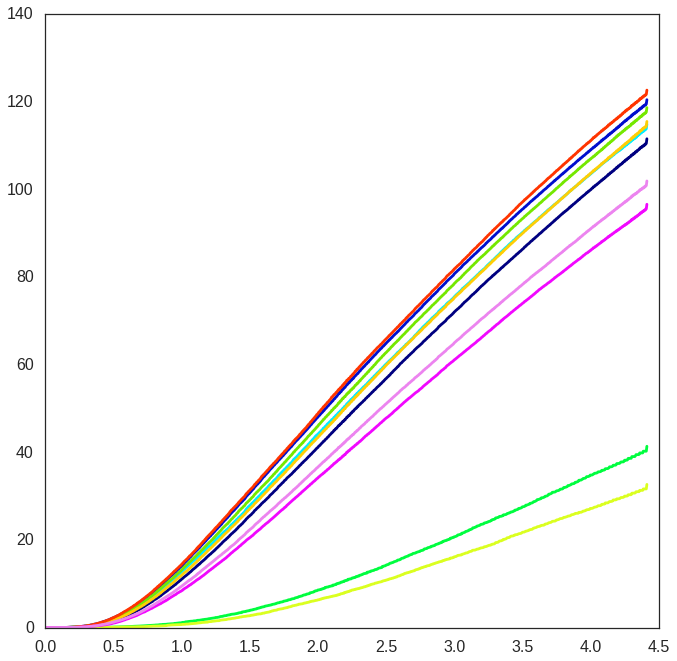

In [35]:
bettisave = np.zeros((1000, len(stims)))
betti = 1
windt = 25.0
for ind, stim in enumerate(stims):
    (avgBetti, t, maxT) = computeAvgBettiCurve(resultsSh, stim, betti, windt, dtOver=12.5)
    bettisave[:, ind] = avgBetti
plt.figure(figsize=(11,11))    
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(stims))])
plt.plot(t, bettisave)
plt.savefig('/home/brad/B604_P01S15_Betti1_AllTrial_AllStims_GoodMUA_shuffled.png', format='png')

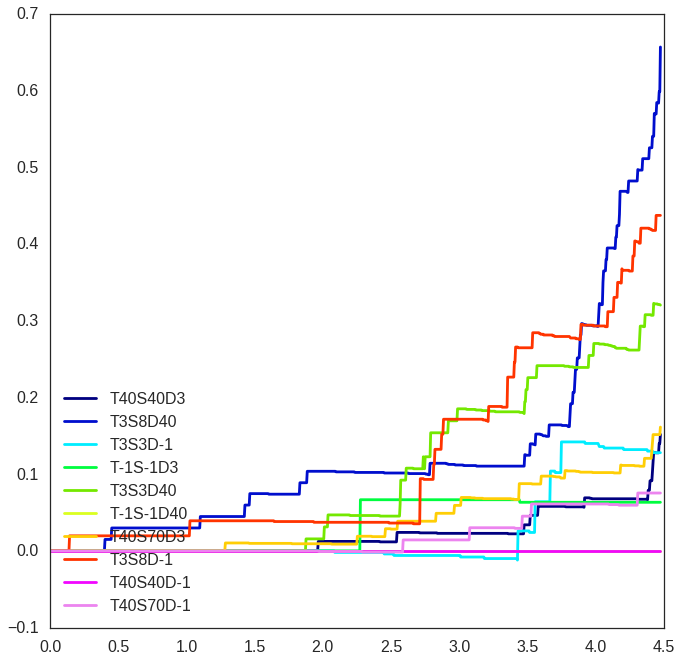

In [31]:
bettisave = np.zeros((1000, len(stims)))
betti = 2
windt = 10.0
for ind, stim in enumerate(stims):
    (avgBettiR, tR, maxTR) = computeAvgBettiCurve(results, stim, betti, windt, dtOver=5.0)
    (avgBetti, t, maxT) = computeAvgBettiCurve(resultsSh, stim, betti, windt, dtOver=5.0)
    bettisave[:, ind] = avgBettiR - avgBetti
plt.figure(figsize=(11,11)) 
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(stims))])
plt.plot(t, bettisave)

plt.legend(stims, loc='lower left')
#plt.savefig('/home/brad/B604_P01S15_Betti1_AllTrial_AllStims_GoodMUA_OriginalMinusShuffled.png', format='png')

In [ ]:
MRs = glob.glob('/home/brad/bcube/experiments/B1083/klusta/phy040516/Pen03_Lft_AP0_ML1000__Site03_Z2700__B1083_cat_P03_S03_1/2016111*')

thresh = 4.0
changedt = [s for s in MRs if s.split('-')[2] == str(thresh)]
cdt_over = sort(changedt)[range(0, len(changedt), 2)]

# All Stims at once across params

In [ ]:
MRs = glob.glob('/Volumes/gentner/btheilma/experiments/B1235/phy051316/Pen02_Lft_AP200_ML800__Site01_Z3000__B1235_cat_P02_S01_1/*masterResults.pkl')

thresh = 4.0
changedt = [s for s in MRs if s.split('-')[3] == str(thresh)]
cdt_over = sort(changedt)
cdt_over

In [ ]:
bettisave = np.zeros((1000, len(stims)))
for resFname in cdt_over:
    print(resFname)
    with open(resFname, 'r') as f:
        mrDict = pickle.load(f)
    windt = float(resFname.split('-')[1])
    dtOvr = float(resFname.split('-')[2])
    computationClass = 'permuted'
    results = mrDict[computationClass]
    resultsSh = mrDict['shuffledpermuted']
    stims = results.keys()
    betti = 1
    for ind, stim in enumerate(stims):
        (avgBetti, t, maxT) = computeAvgBettiCurve(results, stim, betti, windt, dtOvr)
        bettisave[:, ind] = avgBetti
    plt.figure(figsize=(11,11))    
    plt.plot(t, bettisave)
    plt.title('Window Size: {} ms Threshold: {} Betti: {}'.format(windt, thresh, betti))
    plt.xlabel('Time (seconds)')
    plt.ylabel('Betti Number Value')
    plt.savefig('/Users/brad/B1235_P02S01_{}_{}_{}_b{}.pdf'.format(windt, dtOvr, thresh, betti), format='pdf')

In [ ]:
bettisave = np.zeros((1000, len(stims)))
for resFname in cdt_over:
    print(resFname)
    with open(resFname, 'r') as f:
        mrDict = pickle.load(f)
    windt = float(resFname.split('-')[1])
    dtOvr = float(resFname.split('-')[2])
    computationClass = 'permuted'
    results = mrDict[computationClass]
    resultsSh = mrDict['shuffledpermuted']
    stims = results.keys()
    betti = 0
    for ind, stim in enumerate(stims):
        (avgBetti, t, maxT) = computeAvgBettiCurve(results, stim, betti, windt, dtOvr)
        bettisave[:, ind] = avgBetti
    plt.figure(figsize=(11,11))    
    plt.plot(t, bettisave)
    plt.title('Window Size: {} Threshold: {} Betti: {}'.format(windt, thresh, betti))

# All Bettis Avg One Stim

In [ ]:
bettisave = np.zeros((1000, len(stims)))
maxbetti = 3
stim = 'A_scaled_burung'
for resFname in cdt_over:
    print(resFname)
    with open(resFname, 'r') as f:
        mrDict = pickle.load(f)
    windt = float(resFname.split('-')[1])
    dtOvr = float(resFname.split('-')[2])
    computationClass = 'permuted'
    results = mrDict[computationClass]
    resultsSh = mrDict['shuffledpermuted']
    stims = results.keys()
    betti = 1
    for ind, betti in enumerate(range(maxbetti)):
        (avgBetti, t, maxT) = computeAvgBettiCurve(results, stim, betti, windt, dtOvr)
        bettisave[:, ind] = avgBetti
    plt.figure(figsize=(11,11))    
    plt.plot(t, bettisave)
    plt.title('Window Size: {} ms Threshold: {} Stimulus: {}'.format(windt, thresh, stim))
    plt.xlabel('Time (seconds)')
    plt.ylabel('Betti Number Value')
    plt.savefig('/Users/brad/B1235_P02S01_{}_{}_{}_{}.pdf'.format(windt, dtOvr, thresh, stim), format='pdf')

In [ ]:
bettisave = np.zeros((1000, len(stims)))
maxbetti = 3
stim = 'A_scaled_burung'
for resFname in cdt_over:
    print(resFname)
    with open(resFname, 'r') as f:
        mrDict = pickle.load(f)
    windt = float(resFname.split('-')[1])
    dtOvr = float(resFname.split('-')[2])
    computationClass = 'permuted'
    results = mrDict[computationClass]
    resultsSh = mrDict['shuffledpermuted']
    stims = results.keys()
    betti = 1
    fig, axarr = plt.subplots(4,4, figsize=(11,11), sharey=True, sharex=True)
    axarr = axarr.flatten()
    for ind, stim in enumerate(stims):
        #print((ind, stim))
        for ind2, betti in enumerate(range(maxbetti)):
            (avgBetti, t, maxT) = computeAvgBettiCurve(results, stim, betti, windt, dtOvr)
            bettisave[:, ind2] = avgBetti
     
        axarr[ind].plot(t, bettisave)
        #axarr[ind].set_title('Stimulus: {}'.format(stim))
        #axarr[ind].set_xlabel('Time (seconds)')
        #axarr[ind].set_ylabel('Betti Number Value')
    plt.savefig('/Users/brad/B1235_P02S01_{}_{}_{}_{}.pdf'.format(windt, dtOvr, thresh, 'AllStim'), format='pdf')

In [ ]:
bettisave = np.zeros((1000, len(stims)))
ind = 0
fig, axarr = plt.subplots(2,2, figsize=(11,11), sharex=True, sharey=True)
axarr = axarr.flatten()
for ind,resFname in enumerate(cdt_over):
    print(resFname)
    with open(resFname, 'r') as f:
        mrDict = pickle.load(f)
    windt = float(resFname.split('-')[1])
    dtOvr = float(resFname.split('-')[2])
    computationClass = 'permuted'
    results = mrDict[computationClass]
    resultsSh = mrDict['shuffledpermuted']
    stims = results.keys()
    betti = 2
    stim = 'A_scaled_burung'
    (avgBetti, t, maxT) = computeAvgBettiCurve(results, stim, betti, windt, dtOvr)
    (avgBettishuff, t2, maxT2) = computeAvgBettiCurve(resultsSh, stim, betti, windt, dtOvr)
    axarr[ind].plot(t, avgBetti, t2, avgBettishuff)
    axarr[ind].set_title('{} ms'.format(windt))

plt.savefig('/Users/brad/B1235_P02S01_{}_{}_{}_b{}-wshuffledAlldts.pdf'.format(windt, dtOvr, thresh, betti), format='pdf')

In [ ]:
axarr

# Single stim across windts on same plot - constant threshold

In [ ]:
MRs = glob.glob('/home/brad/bcube/experiments/B1083/klusta/phy040516/Pen03_Lft_AP0_ML1000__Site03_Z2700__B1083_cat_P03_S03_1/2016111*')

thresh = 3.0
changedt = [s for s in MRs if s.split('-')[2] == str(thresh)]
cdt_over = sort(changedt)[range(1, len(changedt), 2)]

windts = [5.0, 10.0, 25.0, 50.0]
betti = 2
stim = 'K_40k'
bettisave = np.zeros((1000, len(cdt_over)))
for ind, resFname in enumerate(cdt_over):
    with open(resFname, 'r') as f:
        mrDict = pickle.load(f)
    
    computationClass = 'permuted'
    results = mrDict[computationClass]
    (avgBetti, t, maxT) = computeAvgBettiCurve(results, stim, betti, windts[ind])
    bettisave[:, ind] = avgBetti
plt.figure(figsize=(11,11))    
plt.plot(t, bettisave)
plt.title('')
plt.legend(windts)

In [ ]:
MRs = glob.glob('/home/brad/bcube/experiments/B1083/klusta/phy040516/Pen03_Lft_AP0_ML1000__Site03_Z2700__B1083_cat_P03_S03_1/2016111*')

thresh = 3.0
changedt = [s for s in MRs if s.split('-')[2] == str(thresh)]
cdt_over = sort(changedt)[range(1, len(changedt), 2)]

windts = [5.0, 10.0, 25.0, 50.0]
betti = 2
stim = 'K_40k'
avgbettisave = np.zeros((1000, len(cdt_over)))
stdbettisave = np.zeros((1000, len(cdt_over)))
cisave = np.zeros((1000, len(cdt_over)))
for ind, resFname in enumerate(cdt_over):
    with open(resFname, 'r') as f:
        mrDict = pickle.load(f)
    
    computationClass = 'permuted'
    results = mrDict[computationClass]
    (avgBetti, stdBetti, ci95betti, t, maxT) = computeAvgStdBettiCurve(results, stim, betti, windts[ind])
    avgbettisave[:, ind] = avgBetti
    stdbettisave[:, ind] = stdBetti
    cisave[:, ind] = ci95betti
plt.figure(figsize=(11,11))    
plt.plot(t, avgbettisave)
plt.plot(t, avgbettisave + cisave, 'k.')
plt.plot(t, avgbettisave - cisave, 'k-')
plt.title('yep')
plt.legend(windts)

# Look at changing winsize, constant threshold, with 50% overlap

In [ ]:
MRs = glob.glob('/home/brad/bcube/experiments/B1075/phy041216/Pen01_Lft_AP300_ML700__Site03_Z2700__B1075_cat_P01_S03_1/paramSweep_20161111/*.pkl')

bird = 'B1075'
thresh = 3.0
changedt = [s for s in MRs if s.split('-')[2] == str(thresh)]
cdt_over = sort(changedt)[range(1, len(changedt), 2)]
over = 0.5

windts = [5.0, 10.0, 25.0, 50.0]

bkan = pickle.load(open(cdt_over[0], 'r'))
stims = bkan['permuted'].keys()
bettis = [0,1,2]
for stim in stims:
    for betti in bettis:   
        avgbettisave = np.zeros((1000, len(cdt_over)))
        stdbettisave = np.zeros((1000, len(cdt_over)))
        cisave = np.zeros((1000, len(cdt_over)))
        for ind, resFname in enumerate(cdt_over):
            with open(resFname, 'r') as f:
                mrDict = pickle.load(f)
    
            computationClass = 'permuted'
            results = mrDict[computationClass]
            if over:
                dt = windts[ind]*over
            (avgBetti, stdBetti, ci95betti, t, maxT) = computeAvgStdBettiCurve(results, stim, betti, dt)
            avgbettisave[:, ind] = avgBetti
            stdbettisave[:, ind] = stdBetti
            cisave[:, ind] = ci95betti
        plt.figure(figsize=(11,11))    
        plt.plot(t, avgbettisave)
        plt.plot(t, avgbettisave + cisave, 'k--', linewidth=1)
        plt.plot(t, avgbettisave - cisave, 'k--', linewidth=1)
        plt.title('Bird {} Betti {} Stim {}'.format(bird, betti, stim))
        plt.legend(windts)
        plt.savefig('/home/brad/plots/{}-Betti{}-Stim{}-Thresh{}-Over{}.png'.format(bird, betti, stim, thresh, over))

# Look at changing threshold, constant winsize, with 50% overlap

In [ ]:
MRs = glob.glob('/home/brad/bcube/experiments/B1083/klusta/phy040516/Pen03_Lft_AP0_ML1000__Site03_Z2700__B1083_cat_P03_S03_1/2016111*')
MRs = glob.glob('/home/brad/bcube/experiments/B1075/phy041216/Pen01_Lft_AP300_ML700__Site03_Z2700__B1075_cat_P01_S03_1/paramSweep_20161111/*.pkl')


bird = 'B1075'
winsize = 10.0
changethresh = [s for s in MRs if s.split('-')[1] == str(winsize)]
cdt_over = sort(changethresh)[range(1, len(changethresh), 2)]
over = 0.5

threshs = [3.0, 4.0, 6.0]

bkan = pickle.load(open(cdt_over[0], 'r'))
stims = bkan['permuted'].keys()
bettis = [0,1,2]
for stim in stims:
    for betti in bettis:   
        avgbettisave = np.zeros((1000, len(cdt_over)))
        stdbettisave = np.zeros((1000, len(cdt_over)))
        cisave = np.zeros((1000, len(cdt_over)))
        for ind, resFname in enumerate(cdt_over):
            with open(resFname, 'r') as f:
                mrDict = pickle.load(f)
    
            computationClass = 'permuted'
            results = mrDict[computationClass]
            if over:
                dt =winsize*over
            (avgBetti, stdBetti, ci95betti, t, maxT) = computeAvgStdBettiCurve(results, stim, betti, dt)
            avgbettisave[:, ind] = avgBetti
            stdbettisave[:, ind] = stdBetti
            cisave[:, ind] = ci95betti
        plt.figure(figsize=(11,11))    
        plt.plot(t, avgbettisave)
        plt.plot(t, avgbettisave + cisave, 'k--', linewidth=1)
        plt.plot(t, avgbettisave - cisave, 'k--', linewidth=1)
        plt.title('Bird {} Betti {} Stim {}'.format(bird, betti, stim))
        plt.legend(threshs)
        plt.savefig('/home/brad/plots/{}-Betti{}-Stim{}-WinSize{}-Over{}.png'.format(bird, betti, stim, winsize, over))

In [ ]:
MR = '/home/brad/experiments/B999/20161202T212758Z-25.0-0.0-4.0-masterResults.pkl'
with open(MR, 'r') as f:
    res = pickle.load(f)

# Plot single trial bettis

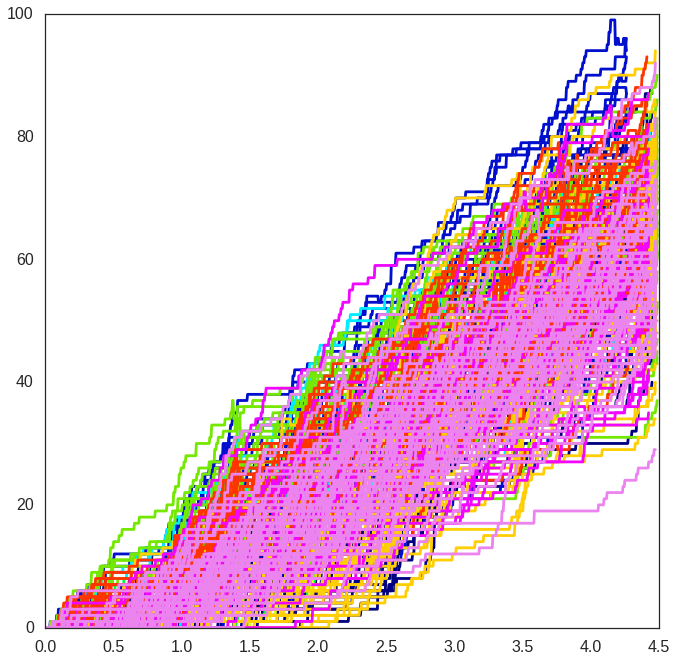

In [64]:
betti = 1

betti = 1
windt = 25.0
stimlist = ['T40S40D3', 'T3S3D-1']
colors = ['r', 'b']
plt.figure(figsize=(11,11))  
colormap = plt.cm.gist_ncar
for cind, stim in enumerate(stims):
    bettisave = np.zeros((1000, len(results[stim].keys())))
    for ind, trial in enumerate(results[stim].keys()):
        (avgBetti, t, maxT) = computeAvgBettiCurveSingleTrial(results, stim, trial, betti, windt, dtOver=12.5)
        bettisave[:, ind] = avgBetti
    plt.plot(t, bettisave, color=colormap(np.linspace(0, 0.9, len(stims))[cind]))



In [48]:
stims


[u'T40S40D3',
 u'T3S8D40',
 u'T3S3D-1',
 u'T-1S-1D3',
 u'T3S3D40',
 u'T-1S-1D40',
 u'T40S70D3',
 u'T3S8D-1',
 u'T40S40D-1',
 u'T40S70D-1']